In [905]:
import cv2

In [396]:
cv2.compareHist(np.array(obstacle), all_vals[-1], cv2.HISTCMP_CORREL)

error: OpenCV(4.6.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/core/src/matrix_iterator.cpp:71: error: (-215:Assertion failed) A.size == arrays[i0]->size in function 'init'


In [833]:
obst_hsv = cv2.cvtColor(np.array(obstacle), cv2.COLOR_BGR2HSV)

In [834]:
in_question_hsv1 = cv2.cvtColor(all_vals[-1], cv2.COLOR_BGR2HSV)

In [835]:
in_question_hsv2 = cv2.cvtColor(all_vals[-2], cv2.COLOR_BGR2HSV)

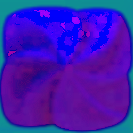

In [836]:
Imag.fromarray(obst_hsv)

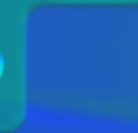

In [837]:
Imag.fromarray(in_question_hsv1)

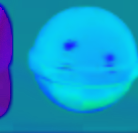

In [838]:
Imag.fromarray(in_question_hsv2)

In [795]:
obst_hist = cv2.calcHist(np.array(obstacle), [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
obst_hist = cv2.normalize(obst_hist, obst_hist).flatten()

In [839]:
h_bins = 50
s_bins = 60
v_bins = 60
histSize = [h_bins, s_bins, v_bins]
# hue varies from 0 to 179, saturation from 0 to 255
h_ranges = [0, 180]
s_ranges = [0, 256]
ranges = h_ranges + s_ranges + [0, 256] # concat lists
# Use the 0-th and 1-st channels
channels = [0, 1, 2]

In [840]:
obst_hist = cv2.calcHist([obst_hsv], channels, None, histSize, ranges, accumulate=False)

In [418]:
in_question1_hist = cv2.calcHist([in_question_hsv1], channels, None, histSize, ranges, accumulate=False)

In [420]:
in_question2_hist = cv2.calcHist([in_question_hsv2], channels, None, histSize, ranges, accumulate=False)

In [450]:
cv2.compareHist(obstacle_hist, bg_hist, cv2.HISTCMP_CORREL)

-0.0028837977779950113

In [457]:
cv2.compareHist(templates_hists['obstacle'], in_question2_hist, cv2.HISTCMP_CORREL)

KeyError: 'obstacle'

In [906]:
from itertools import product, chain
from IPython.display import Image, display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from time import sleep
from PIL import Image as Imag
import pyautogui
import pandas as pd
from copy import deepcopy

In [907]:
# Legal moves list
candy_all=['blue', 'red', 'green', 'violet', 'orange']

In [908]:
def closeButtonLookup():
    '''Looks for close button and presses it returns False if close button is not found, else - True'''
    if bool(pyautogui.locateCenterOnScreen('Images/btn_close.png', confidence=0.7))==True:
        x, y = pyautogui.locateCenterOnScreen('Images/btn_close.png', confidence=0.7)
        pyautogui.click(x/2, y/2, duration=0.5, button='right')
        print('OK,I am out of here!')
        return True
    return False

In [909]:
class GameState():  
    '''Game state, board = dataframe, 'frm' and 'at' = lists of row/colum indices of the swapped candies'''
    def __init__(self,  board, parent=None, frm=None, at=None):
        self.board = board
        self.parent = parent
        self.frm = frm
        self.at = at
        self.score = 0
        self.super = False
        self.matches = list()
        self.children = list()
        self.all_tiles = list(product(range(0, board_h),range(0, board_w)))
        self.legal_moves = [tile for tile in self.all_tiles if self.board.iloc[tile[0], tile[1]] in ['blue', 'red', 'green', 'violet', 'orange']]

    def generate_children(self):       
        directions = np.array([[1, 0], [0, 1], [-1, 0], [0, -1]])
        for origin in self.legal_moves:           
            positions = np.array(origin)
            moves = np.add(positions, directions)
            # Filter the legal_tiles moves and save them in a children nodes attribute
            for move in moves:
                if tuple(move) in legal_tiles:
                    test_board = self.board.copy()
                    test_board.loc[origin[0], origin[1]], test_board.loc[move[0], move[1]] = test_board.loc[move[0], move[1]], test_board.loc[origin[0], origin[1]]
                    match1, utility1 = eval_tile(test_board, origin)
                    match2, utility2 = eval_tile(test_board, move)
                    utility = utility1 + utility2
                    matches = match1 + match2
                    if utility >= 3:
                        child = GameState(test_board, frm=origin, at=tuple(move))
                        child.score = utility
                        child.matches = matches
                        self.children.append(child)        

In [910]:
class Match():   
    '''Match contains info on size, position and type of candy'''  
    def __init__(self, typ, pos):
        self.size = pos.shape[0]
        self.pos = pos
        self.typ = typ
        obstacles = np.empty([1,1])

In [911]:
def rake(series, start):
    '''Consider the column in a table with variety of values in each cell.
    We choose the start cell and 'rake' upwards as long as values of the sells
    stay the same as in the start cell,
    then downwhads on the same condition, but this time saving the cells indices, thus
    we get an array of matching values and its members positions in the column.
    Takes Series and a scalar
    Returns list of indices'''
    spec = series[start]
    match_indices = []
    upper_limit = start
    up = series[:start]
    while list(up):
        ind=up.index.max()
        sample = up.pop(ind)
        if sample == spec:
            upper_limit = ind
        if not sample == spec:
            break
    down = series[upper_limit:]
    while list(down):
        ind = down.index.min()
        sample = down.pop(ind)
        if sample == spec:
            match_indices.append(ind)
        if not sample == spec:
            break
    return match_indices

In [912]:
def eval_tile(board, pos):
    '''Given a tile coordinates rake the grid column-vise and row-wize.
    returns available matches, value of the move'''
    row_index = pos[0]
    column_index = pos[1]
    columns_matches = rake(board.loc[row_index], column_index)
    row_matches = rake(board.loc[:,column_index], row_index)   
    all_matches = [i for i in 
                   [board.loc[row_index, columns_matches], board.loc[row_matches, column_index]] 
                   if len(i)>=3]
    value = len(list(chain(*all_matches)))
    if len(all_matches)>1:
        value -=1
    return all_matches, value

In [921]:
def get_hist(array):
    image_hsv = cv2.cvtColor(array, cv2.COLOR_BGR2HSV)
    h_bins = 50
    s_bins = 60
    v_bins = 60
    histSize = [h_bins, s_bins, v_bins]
    # hue varies from 0 to 179, saturation and value from 0 to 255
    h_ranges = [0, 180]
    s_ranges = [0, 256]
    ranges = h_ranges + s_ranges + [0, 256] # concat lists
    # Use the all channels
    channels = [0, 1, 2]
    hist = cv2.calcHist([image_hsv], channels, None, histSize, ranges, accumulate=False)
    cv2.normalize(hist, hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    return hist

#### Get input for board height and width.

In [914]:
board_w = int(input('Borad width is:  '))

Borad width is:  7


In [915]:
board_h = int(input('Borad height is: '))

Borad height is: 6


In [916]:
tile_w = 138
tile_h = 133
tilesize = np.array([tile_h, tile_w])

In [917]:
screensize = pyautogui.size()

In [918]:
green = cv2.imread('Images/candy_green.png')
violet = cv2.imread('Images/candy_violet.png')
blue = cv2.imread('Images/candy_blue.png')
orange = cv2.imread('Images/candy_orange.png')
red = cv2.imread('Images/candy_red.png')
obstacle = cv2.imread('Images/obstacle_1.png')
bg = cv2.imread('Images/bg.png')
red=cv2.imread('Images/candy_red.png')

#### Export the element image:

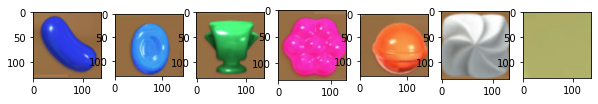

In [919]:
fig = plt.figure(figsize=(10, 7))
rows =1
columns =7
count=0
for im in [red, orange, green, violet, blue, obstacle, bg]:
    count+=1
    fig.add_subplot(rows, columns, count)
    plt.imshow(im)   

In [925]:
# Create histograms of elements
blue_hist = get_hist(np.array(blue))
orange_hist = get_hist(np.array(orange))
red_hist = get_hist(np.array(red))
violet_hist = get_hist(np.array(violet))
green_hist = get_hist(np.array(green))
obstacle_hist = get_hist(np.array(obstacle))
bg_hist = get_hist(np.array(bg))

In [926]:
# Create dictionary of elements and their histograms
templates_hists = {}
histograms = [green_hist, blue_hist, violet_hist, orange_hist, obstacle_hist, bg_hist]
elements =['green','blue','violet','orange','obstacle','bg']
for key,val in zip(elements, histograms):
    templates_hists.setdefault(key, val)

In [889]:
all_tiles = list(product(range(0, board_h),range(0, board_w)))

#### Create a dictionary of coordinates for mouse drags.

In [755]:
game_scr_size =  board_w * tile_w, board_h * tile_h
corner = screensize[1]*2 - game_scr_size[1]
tilecenters = {pos:(np.flip(np.array(pos)*tilesize+np.array([screensize[1]*2 - game_scr_size[1],0])+67)/2).astype(int) for pos in all_tiles}

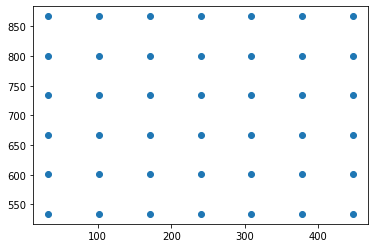

In [756]:
df = pd.DataFrame(tilecenters.values())
plt.scatter(df[0], df[1])

## Scan the game area, identify the cell content.

In [801]:
t=pyautogui.screenshot('Images/board_ss.png',region=(10, corner, game_scr_size[0], game_scr_size[1]))

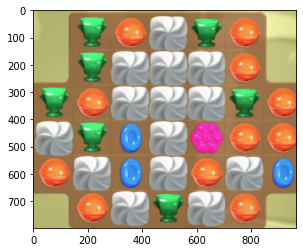

In [922]:
image = cv2.imread("Images/board_ss.png")
image_array = np.array(image)
plt.imshow(image)

### Save BG tile

### Split game ss to tiles.

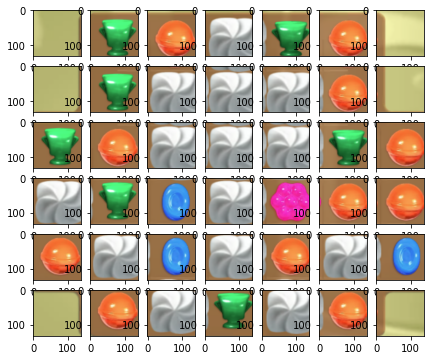

In [923]:
all_vals = []
fig = plt.figure(figsize=(board_w, board_h))
rows = board_h
columns = board_w
count=0  
for i in all_tiles:
    count+=1
    fig.add_subplot(rows, columns, count)
    starts = np.array(i) 
    ends = np.array(i)+1
    start = (starts * tilesize ).astype(int)
    end = (ends * tilesize).astype(int)
    all_vals.append(image_array[start[0]:end[0], start[1]:end[1]])
    plt.imshow(image_array[start[0]:end[0], start[1]:end[1]])

## Create a representation of the game board.

In [927]:
board = pd.DataFrame('0', index=range(board_h), columns=range(board_w))
for pos, array in zip(all_tiles, all_vals):
    # get hist
    tile_hist = get_hist(array)
    typ = max(templates_hists, key=lambda x: cv2.compareHist(templates_hists[x], tile_hist, 0))
    board.loc[pos] = typ

In [928]:
Root = GameState(board)

In [930]:
Root.board

,0,1,2,3,4,5,6
0,bg,orange,orange,orange,green,blue,green
1,blue,green,obstacle,obstacle,obstacle,blue,blue
2,green,green,obstacle,obstacle,obstacle,blue,green
3,green,green,green,green,violet,blue,green
4,green,green,green,green,blue,obstacle,green
5,blue,blue,obstacle,orange,orange,blue,bg


In [931]:
Root.generate_children()

In [932]:
best = max(Root.children, key=lambda x: x.score)

In [933]:
best.board

,0,1,2,3,4,5,6
0,bg,orange,orange,orange,green,blue,green
1,blue,green,obstacle,obstacle,obstacle,blue,blue
2,green,green,obstacle,obstacle,obstacle,blue,green
3,green,green,green,green,violet,blue,green
4,green,green,green,green,blue,obstacle,green
5,blue,blue,obstacle,orange,orange,blue,bg


In [786]:
print(f'from {best.frm}\nto {best.at}')

from (0, 6)
to (0, 5)


In [767]:
best.score

4

In [789]:
pyautogui.moveTo(tilecenters[best.frm][0], tilecenters[best.frm][1])
pyautogui.dragTo(tilecenters[tuple(best.at)][0], tilecenters[tuple(best.at)][1], button='right')

## Look for the matches

### TODO:
collapse matches: 
- create empty cells where matches are 
- move remaining candies to fill the space.

### Testing!